<a href="https://colab.research.google.com/github/arkadijshmelev/Taxi-cost-prediction/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Необходимо решить задачу машинного обучения, направленную на автоматизацию бизнес процессов. Построить модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда едут, в какое время суток совершается поездка, погодных условий и так далее. 

С помощью алгоритма, способного определять длительность поездки, возможно будет прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси (решаем задачу регрессии).

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных




## 2. Знакомство с данными, базовый анализ и расширение данных

Познакомимся с предоставленными данными. Подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Импортируем модули, которые нам понадобятся для решения задачи:

In [ ]:
# !pip install -U pandas numpy scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Прочитаем наш файл с исходными данными:

In [ ]:
train = drive.CreateFile({'id': '1lt0fk2tSgbumOSr8sevSMzHxa26KdNGB'})
train.GetContentFile('data/train.csv')

In [ ]:
taxi_data = pd.read_csv('data/train.csv')
print('Train data shape: {}'.format(taxi_data.shape))
display(taxi_data.head())

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Условно разделилим признаки нескольких групп.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

Посмотрим на временные рамки, в которых мы работаем с данными.

Переведем признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определим временные рамки (без учета времени), за которые представлены данные.

In [ ]:
taxi_data.pickup_datetime = pd.to_datetime(taxi_data.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
taxi_data.dropoff_datetime = pd.to_datetime(taxi_data.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
print('Данные представллены за период:')
print(taxi_data.pickup_datetime.dt.date.min(), '-', taxi_data.pickup_datetime.dt.date.max())

Данные представллены за период:
2016-01-01 - 2016-06-30


Посмотрим на пропуски. 
Выведем информацию о пропущенных значений в данных (суммарно по всем столбцам таблицы)?

In [ ]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Посмотрим на статистические характеристики некоторых признаков. 

Выведем сколько уникальных таксопарков присутствует в данных, каково максимальное количество пассажиров,
чему равна средняя и медианная длительность поездки, чему равно минимальное и максимальное время поездки (в секундах)?


In [ ]:
# Выведем статистические данные.
display(taxi_data.describe())
display(taxi_data.describe(include='object'))

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


,id,store_and_fwd_flag
count,1458644,1458644
unique,1458644,2
top,id2875421,N
freq,1,1450599


In [ ]:
print('Количество уникальных таксопарков -', taxi_data.vendor_id.nunique())	
print('Максимальное количество пассажиров -', taxi_data.passenger_count.max())
print('Среднее время поездки -', round(taxi_data.trip_duration.mean()), 'секунд')
print('Медианное время поездки -', round(taxi_data.trip_duration.median()), 'секунды')
print('Минимальное время поездки -', round(taxi_data.trip_duration.min()), 'секунда')
print('Мааксимальное время поездки -', round(taxi_data.trip_duration.max()), 'секунды')

Количество уникальных таксопарков - 2
Максимальное количество пассажиров - 9
Среднее время поездки - 959 секунд
Медианное время поездки - 662 секунды
Минимальное время поездки - 1 секунда
Мааксимальное время поездки - 3526282 секунды


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

Выведем сколько поездок было совершено в субботу, сколько поездок в среднем совершается в день? 

In [ ]:
def add_datetime_features(df):
    
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    
    return df
    
taxi_data = add_datetime_features(taxi_data)
display(taxi_data.head())
print('Количество поездок, совершенных в субботу -', taxi_data[taxi_data['pickup_day_of_week'] == 'Saturday'].shape[0])
print('Среднее количество поездок за день -', round(taxi_data['id'].nunique() / taxi_data['pickup_date'].nunique()))


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday


Количество поездок, совершенных в субботу - 220868
Среднее количество поездок за день - 8015


Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Выведем чему равна медианная длительность поездки на такси в праздничные дни? 


In [ ]:
holiday_data = drive.CreateFile({'id': '1qL8AlWWxEDZdzKWM2sFYogpZC1V8kBmI'})
holiday_data.GetContentFile('data/holiday_data.csv')

In [ ]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

In [ ]:
def add_holiday_features(df1, df2):
    
    df2['date'] = pd.to_datetime(df2['date']).dt.date
    df = df1.merge(df2, left_on='pickup_date', right_on='date', how='left')
    df['holiday'] = df['holiday'].fillna(0)
    df['pickup_holiday'] = df['holiday'].apply(lambda x: 0 if x == 0 else 1)
    df = df.drop(['day', 'date', 'holiday'], axis=1)
    
    return df

taxi_data = add_holiday_features(taxi_data, holiday_data)
taxi_data.head()

print('Медианная длительность поездки в праздничные дни -', taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median())

Медианная длительность поездки в праздничные дни - 585.0


Реализуум функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

Выведем чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM, сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [ ]:
osrm_data_train = drive.CreateFile({'id': '1s5st6GwUxAl2AfaRGNxf5S9pPsNOdUJs'})
osrm_data_train.GetContentFile('data/osrm_data_train.csv')

In [ ]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')

In [ ]:
def add_osrm_features(df1, df2):
    
    df2 = df2[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    df = df1.merge(df2, on='id', how='left')
    
    return df

taxi_data = add_osrm_features(taxi_data, osrm_data)
display(taxi_data.head())

print('Разница медианной длительностью поездки:')
print(round(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()))


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0


Разница медианной длительностью поездки:
372


In [ ]:
# Проверим наличие пропусков в новом датафрейме.
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [ ]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Выведем чему равно медианное расстояние Хаверсина поездок (в киллометрах)?


In [ ]:
def add_geographical_features(df):


  lat1 = df['pickup_latitude']
  lng1 = df['pickup_longitude']
  lat2 = df['dropoff_latitude']
  lng2 = df['dropoff_longitude']

  df['haversine_distance'] = get_haversine_distance(lat1, lng1, lat2, lng2)
  df['direction'] = get_angle_direction(lat1, lng1, lat2, lng2)
  
  return df

taxi_data = add_geographical_features(taxi_data)
display(taxi_data.head())

print('Медианное растояние Хаверсина равно -', round(taxi_data['haversine_distance'].median(), 2))

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585


Медианное растояние Хаверсина равно - 2.09


Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Выведем сколько поездок содержится в наименьшем по размеру географическом кластере?


In [ ]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

KMeans(n_clusters=10, random_state=42)

In [ ]:
def add_cluster_features(df, cluster_model):

  df['geo_cluster'] = cluster_model.predict(df[['pickup_latitude', 'pickup_longitude',
                                                'dropoff_latitude', 'dropoff_longitude']])
  
  return df

taxi_data = add_cluster_features(taxi_data, kmeans)
display(taxi_data.head())

print('Коилчество поездок в наименьшем кластере -', taxi_data['geo_cluster'].value_counts().min())

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196,9
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768,4
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165,4
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585,9


Коилчество поездок в наименьшем кластере - 2


Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

Выведем сколько поездок было совершено в снежную погоду, сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? 

In [ ]:
weather_data = drive.CreateFile({'id': '1CLKUbvaDOw5kVkfuqv3H5JzWHO94PqR5'})
weather_data.GetContentFile('data/weather_data.csv')

In [ ]:
weather_data = pd.read_csv('data/weather_data.csv')

In [ ]:
def add_weather_features(df1, df2):

  weather_data['time'] = pd.to_datetime(weather_data['time'])
  weather_data['date'] = weather_data['time'].dt.date
  weather_data['hour'] = weather_data['time'].dt.hour

  df2 = df2[['temperature', 'visibility', 'wind speed', 'precip', 'events', 'date', 'hour']]
  df1 = df1.merge(df2, left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'], how='left')
  df1 = df1.drop(['date', 'hour'], axis=1)

  return df1

taxi_data = add_weather_features(taxi_data, weather_data)
display(taxi_data.head())

print('Количество поездок в снежную погоду -', taxi_data['events'].value_counts()['Snow'])
print('Количество пропусков -', np.round(taxi_data.isnull().sum().max() / taxi_data.shape[0] * 100, 2))


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None


Количество поездок в снежную погоду - 13126
Количество пропусков - 0.82


Реализуем функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция будет заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируем данные по столбцу pickup_date и рассчитаем медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполним пропуски. 
Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам. 

Выведем чему равна медиана в столбце temperature после заполнения пропусков? 


In [ ]:
def fill_null_weather_data(df):
    
    weather_col = ['temperature', 'visibility', 'wind speed', 'precip', 'events']
    osrm_col = ['total_distance', 'total_travel_time', 'number_of_steps']

    for col in weather_col:

      if col == 'events':
        df['events'] = df['events'].fillna('None')
      else:
        df[col] = df[col].fillna(
           df.groupby('pickup_date')[col].transform('median')
           )
    
    for col in osrm_col:

      df[col] = df[col].fillna(df[col].median())

    return df
           
taxi_data = fill_null_weather_data(taxi_data)
display(taxi_data.head())
display(taxi_data.isnull().sum())
print('Медиана равна -', taxi_data['temperature'].median())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        0
total_travel_time     0
number_of_steps       0
haversine_distance    0
direction             0
geo_cluster           0
temperature           0
visibility            0
wind speed            0
precip                0
events                0
dtype: int64

Медиана равна - 11.1


Найдем очевидные выбросы в целевой переменной - длительности поездки. 

Условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если построить диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


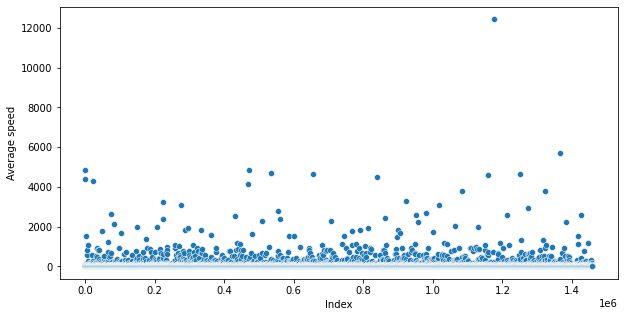

In [ ]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Здесь видно, что есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


Найдем поездки, длительность которых превышает 24 часа. И удалим их из набора данных.

Выведем сколько выбросов по признаку длительности поездки удалось найти?

Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалим их из данных. 

Выведем сколько выбросов по признаку скорости удалось найти?

In [ ]:
# Переведем часы в секунды.
t = 24 * 3600
# Найдем количество наблюдений до фильтрации.
quantity_before = taxi_data.shape[0]
taxi_data = taxi_data[taxi_data['trip_duration'] <= t]
quantity_after = taxi_data.shape[0]
print('Количество найденных значений -', quantity_before - quantity_after)
taxi_data.shape


Количество найденных значений - 4


(1458640, 26)

In [ ]:
outliers_speed = list(taxi_data[avg_speed > 300].index)
taxi_data = taxi_data.drop(outliers_speed)
taxi_data.shape

<ipython-input-28-9bcd0297053d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_speed = list(taxi_data[avg_speed > 300].index)


(1458233, 26)

## 3. Разведывательный анализ данных (EDA)

В этой части проекта:
* Исследуем сформированный набор данных; 
* Найдем закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним анализ визуализациями, иллюстрирующими; исследование. 


Начнем с целевого признака. Основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [ ]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration'] + 1)

Построем гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделаем предположение, является ли полученное распределение нормальным? 
Проверем свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

Найдем чему равен вычисленный p-value, является ли распределение длительности поездок в логарифмическом масштабе нормальным?

Text(0.5, 1.0, 'Boxplot trip diration (log)')

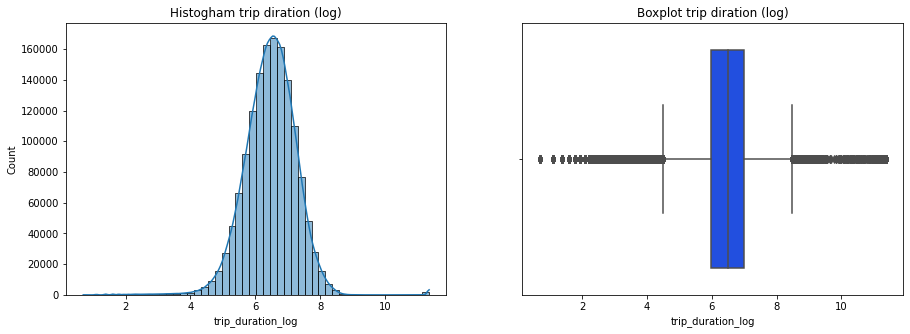

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    ax=axes[0],
    bins=50,
    kde=True,
    palette='bright'
)
axes[0].set_title('Histogham trip diration (log)')

sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Boxplot trip diration (log)')


In [ ]:
H0 = 'Данные распределены нормально'
H1 = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

_, p_value = stats.normaltest(taxi_data['trip_duration_log'])
print('p_value - {:.3f}'.format(p_value))

if p_value > alpha / 2:
  print(H0)
else:
  print(H1)

p_value - 0.000
Данные не распределены нормально (мы отвергаем H0)


Построем визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравним два распределения между собой.

Text(0.5, 1.0, 'Violinplot trip diration (log) by vendor')

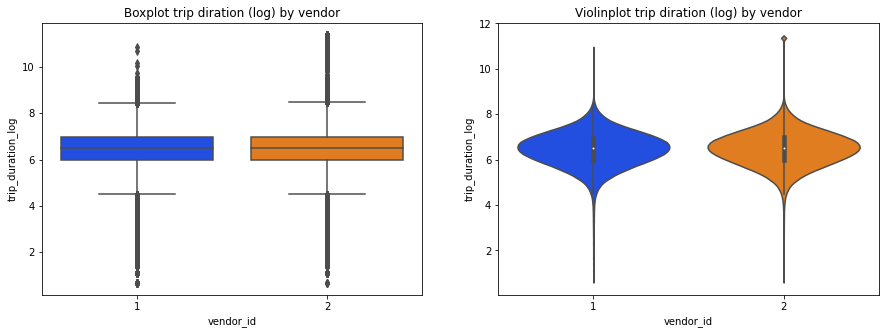

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(
    data=taxi_data,
    y='trip_duration_log',
    x='vendor_id',
    ax=axes[0],
    palette='bright'
)
axes[0].set_title('Boxplot trip diration (log) by vendor')

sns.violinplot(
    data=taxi_data,
    y='trip_duration_log',
    x='vendor_id',
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Violinplot trip diration (log) by vendor')


Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравним два распределения между собой.

Text(0.5, 1.0, 'Violinplot trip diration (log) by SaFf')

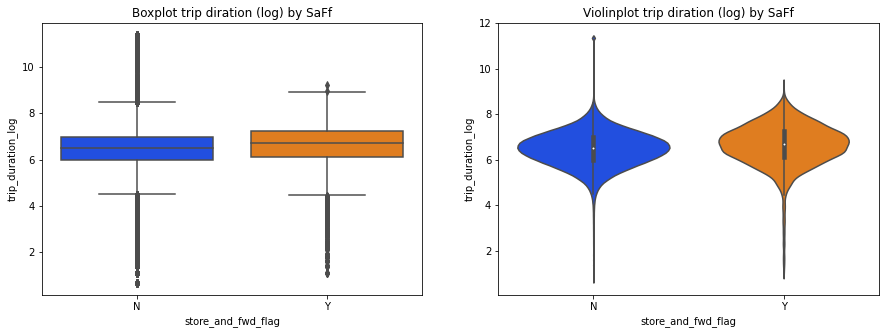

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(
    data=taxi_data,
    y='trip_duration_log',
    x='store_and_fwd_flag',
    ax=axes[0],
    palette='bright'
)
axes[0].set_title('Boxplot trip diration (log) by SaFf')

sns.violinplot(
    data=taxi_data,
    y='trip_duration_log',
    x='store_and_fwd_flag',
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Violinplot trip diration (log) by SaFf')


Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответим на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

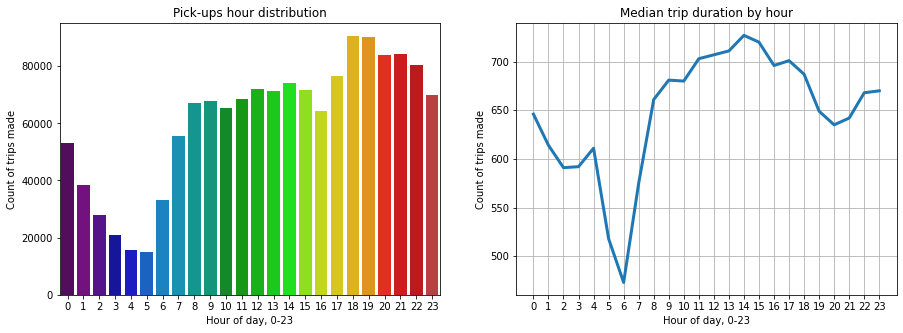

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(
    data=taxi_data,
    x='pickup_hour',
    ax=axes[0],
    palette='nipy_spectral'
)
axes[0].set_title('Pick-ups hour distribution')
axes[0].set_xlabel('Hour of day, 0-23')
axes[0].set_ylabel('Count of trips made')

median_duration_hour = taxi_data.groupby(['pickup_hour'])['trip_duration'].median().reset_index().rename(
    columns={'trip_duration' : 'median_trip_duration'}
    )

sns.lineplot(
    data=median_duration_hour,
    x='pickup_hour',
    y='median_trip_duration',
    lw=3,
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Median trip duration by hour')
axes[1].set_xlabel('Hour of day, 0-23')
axes[1].set_ylabel('Count of trips made')
axes[1].grid()
axes[1].set_xticks(taxi_data['pickup_hour'].unique());


Из графиков видно, что:

а) реже всего такси заказывают с 00:00 до 6:00;

б) медианный пик поездок наблюдается в 14:00.

Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответим на следующие вопросы:

а) В какой день недели совершается больше всего поездок?

б) В какой день недели медианная длительность поездок наименьшая?


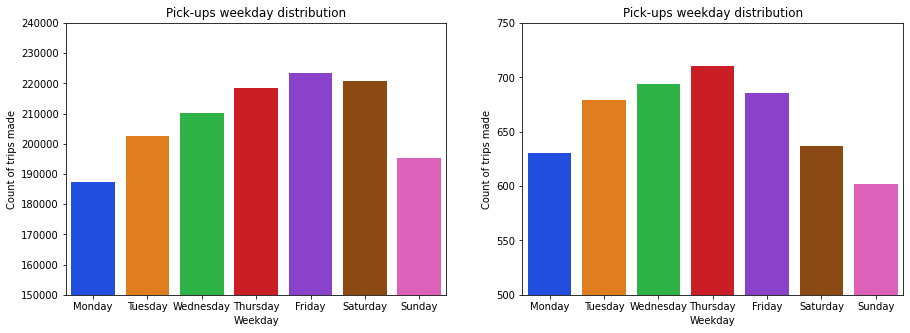

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ordered_dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.countplot(
    data=taxi_data,
    x='pickup_day_of_week',
    order=ordered_dow,
    ax=axes[0],
    palette='bright'
)
axes[0].set_title('Pick-ups weekday distribution')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Count of trips made')
axes[0].set_ylim(15*10e3, 24*10e3)

median_duration_dow = taxi_data.groupby(['pickup_day_of_week'])['trip_duration'].median().reset_index().rename(
    columns={'trip_duration' : 'median_trip_duration'}
    )

sns.barplot(
    data=median_duration_dow,
    x='pickup_day_of_week',
    y='median_trip_duration',
    order=ordered_dow,
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Pick-ups weekday distribution')
axes[1].set_xlabel('Weekday')
axes[1].set_ylabel('Count of trips made')
axes[1].set_ylim(500, 750);


На основе построенных графиков видно, что:

а) в пятницу совершается наибольшее количество поездок;

б) в воскресенье медианное количесво поездок наименьшее.

Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты.

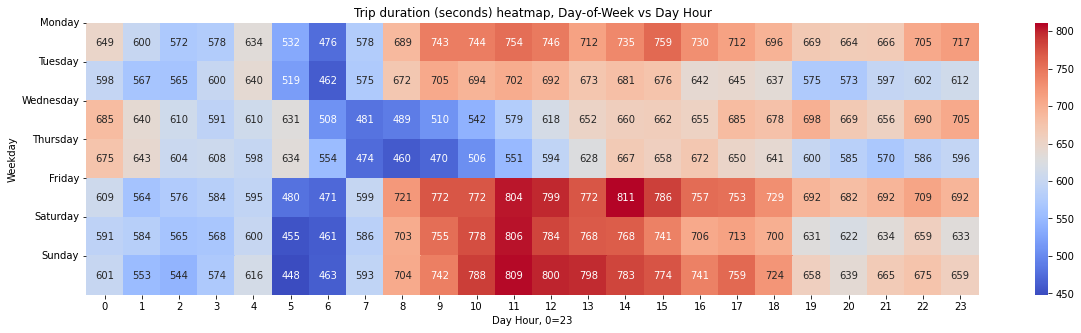

In [ ]:
pivot_data = taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_day_of_week',
    columns='pickup_hour',
    aggfunc='median'
)

fig, axes = plt.subplots(figsize=(20, 5))
sns.heatmap(
    data=pivot_data,
    annot=True,
    fmt='.0f',
    ax=axes,
    cmap='coolwarm'
)
axes.set_title('Trip duration (seconds) heatmap, Day-of-Week vs Day Hour')
axes.set_xlabel('Day Hour, 0=23')
axes.set_ylabel('Weekday')
plt.yticks(range(0, 7), ordered_dow, rotation='horizontal');

Построим две диаграммы рассеяния (scatter-диаграммы):
* первая иллюстрирует географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая - географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложим широту (longitude), а по оси ординат - долготу (latitude). 
Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 


/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


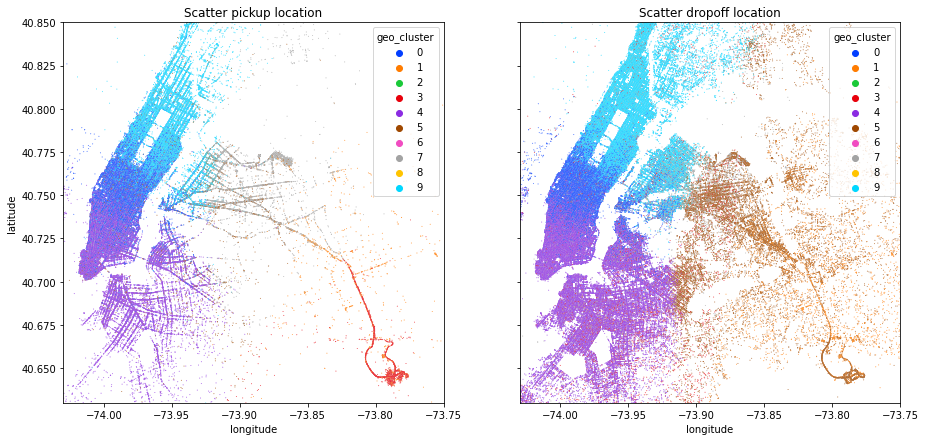

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))

sns.scatterplot(
    data=taxi_data,
    x='pickup_longitude', 
    y='pickup_latitude',
    hue='geo_cluster',
    s=1,
    alpha=.8,
    ax=axes[0],
    palette='bright'
)
axes[0].set_title('Scatter pickup location')
axes[0].set_xlabel('longitude')
axes[0].set_ylabel('latitude')
axes[0].set_xlim(city_long_border)
axes[0].set_ylim(city_lat_border)

sns.scatterplot(
    data=taxi_data,
    x='dropoff_longitude', 
    y='dropoff_latitude',
    hue='geo_cluster',
    s=1,
    alpha=.8,
    ax=axes[1],
    palette='bright'
)
axes[1].set_title('Scatter dropoff location')
axes[1].set_xlabel('longitude')
axes[1].set_ylabel('latitude')
axes[1].set_xlim(city_long_border)
axes[1].set_ylim(city_lat_border);

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, сделаем следующее.
* Закодируем категориальные признаки;
* Отберем признаки, которые будем использовать для обучения модели;
* Масштабироуем и трансформируем некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [ ]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [ ]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


Сразу позаботимся об очевидных неинформативных и избыточных признаках. 


In [ ]:
drop_columns = ['id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 25)


Ранее была извлечена вся необходимая информация из даты начала поездки, теперь можно избавиться от этих признаков, так как они больше не понадобятся:


In [ ]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитаем среднее по закодированному столбцу vendor_id. 

б) Рассчитаем среднее по закодированному столбцу store_and_fwd_flag. 


In [ ]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
print("Среднее по признаку 'vendor_id' -", round(train_data['vendor_id'].mean(), 2))
print("Среднее по признаку 'store_and_fwd_flag' -", round(train_data['store_and_fwd_flag'].mean(), 3))


Среднее по признаку 'vendor_id' - 0.53
Среднее по признаку 'store_and_fwd_flag' - 0.006


Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder получим безымянный numpy-массив, который преобразуем обратно в DataFrame. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). 

В результате получим DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 





In [ ]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
one_hot_encoder = preprocessing.OneHotEncoder(drop='first')

data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
print(data_onehot.shape)


(1458233, 18)


Добавим полученную таблицу с закодированными признаками:

In [ ]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [ ]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все модели будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [ ]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

Оставим лишь те признаки, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке, используя параметр score_func = f_regression.

Укажим признаки, которые вошли в список отобранных


In [ ]:
selector = feature_selection.SelectKBest(
    score_func=feature_selection.f_regression,
    k=25
)
selector.fit(X_train, y_train_log)
best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]

Так как будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то заранее позаботимся о масштабировании факторов. 


Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn.

Рассчитаем среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. 


In [ ]:
scaler = preprocessing.MinMaxScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_valid_scaler = scaler.transform(X_valid)

print(round(X_valid_scaler[:, 0].mean(), 2))

0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. В качестве метрики будем использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Так как логарифмирование целевого признака уже провели заранее, поэтому будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Построим модель линейной регрессии на обучающей выборке.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. 


In [ ]:
ln = linear_model.LinearRegression()

ln.fit(X_train_scaler, y_train_log)

y_train_log_pred = ln.predict(X_train_scaler)
y_valid_log_pred = ln.predict(X_valid_scaler)

print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

RMSLE metric - 0.54
RMSLE metric - 0.54


Сгенерирем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставим в значение False.

Построим модель полиномиальной регрессии 2-ой степени на обучающей выборке.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. 



In [ ]:
# poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

# X_train_scaler_poly = poly.fit_transform(X_train_scaler)
# X_valid_scaler_poly = poly.fit_transform(X_valid_scaler)

# lr = linear_model.LinearRegression()

# lr.fit(X_train_scaler_poly, y_train_log)
# y_train_poly_pred = lr.pridict(X_train_scaler_poly)
# y_valid_poly_pred = lr.pridict(X_valid_scaler_poly)

# print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_poly_pred))))
# print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_poly_pred))))

Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке. Коэффициент регуляризации $\alpha$ установим равным 1, остальные параметры остануться по умолчанию.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [ ]:
# from pandas.core.common import random_state
# poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

# X_train_scaler_poly = poly.fit_transform(X_train_scaler)
# X_valid_scaler_poly = poly.fit_transform(X_valid_scaler)

# ridge = linear_model.Ridge(alpha=1)

# ridge.fit(X_train_scaler_poly, y_train_log)
# y_train_poly_pred = ridge.predict(X_train_scaler_poly)
# y_valid_poly_pred = ridge.predict(X_valid_scaler_poly)

# print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_poly_pred))))
# print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_poly_pred))))

Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке. 

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. 

In [ ]:
tr = tree.DecisionTreeRegressor(random_state=42)

tr.fit(X_train_scaler, y_train_log)

y_train_log_pred = tr.predict(X_train_scaler)
y_valid_log_pred = tr.predict(X_valid_scaler)

print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

RMSLE metric - 0.00
RMSLE metric - 0.57


Переберем все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Построим линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдем оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Выведем значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? 


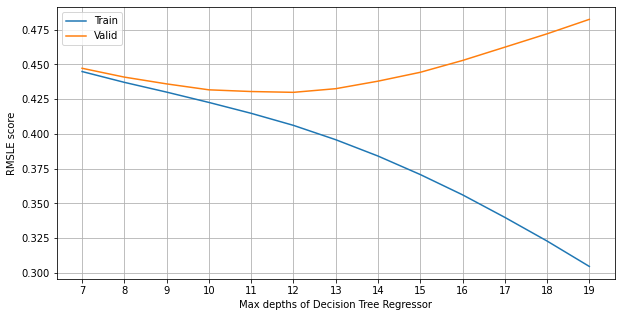

In [ ]:
max_depths = range(7, 20)
train_scores = []
valid_scores = []

for max_depth in max_depths:

  dt = tree.DecisionTreeRegressor(max_depth=max_depth, random_state=42)
  dt.fit(X_train_scaler, y_train_log)
  y_train_log_pred = dt.predict(X_train_scaler)
  y_valid_log_pred = dt.predict(X_valid_scaler)
  train_scores.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred)))
  valid_scores.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)))

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=max_depths, y=train_scores, label='Train')
sns.lineplot(x=max_depths, y=valid_scores, label='Valid')
ax.set_xlabel('Max depths of Decision Tree Regressor')
ax.set_ylabel('RMSLE score')
ax.set_xticks(max_depths)
ax.grid();

In [ ]:
dt = tree.DecisionTreeRegressor(max_depth=12, random_state=42)

dt.fit(X_train_scaler, y_train_log)

y_train_log_pred = dt.predict(X_train_scaler)
y_valid_log_pred = dt.predict(X_valid_scaler)

print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))))
print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))))

RMSLE metric - 0.41
RMSLE metric - 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Построим модель случайного леса на обучающей выборке.

В качестве гиперпараметров укажим следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. 

In [ ]:
ens_tr = ensemble.RandomForestRegressor(
    n_estimators = 200,
    max_depth = 12,
    criterion = 'squared_error',
    min_samples_split = 20,
    random_state = 42,
    verbose=True,
    n_jobs=-1
)

ens_tr.fit(X_train_scaler, y_train_log)

y_train_scaler_pred = ens_tr.predict(X_train_scaler)
y_valid_scaler_pred = ens_tr.predict(X_valid_scaler)

print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_scaler_pred))))
print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_scaler_pred))))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 18.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   17.8s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   18.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.0s


RMSLE metric - 0.40
RMSLE metric - 0.41


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    9.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    9.4s finished


Построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке.

В качестве гиперпараметров укажим следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. 

In [ ]:
gb = ensemble.GradientBoostingRegressor(
    learning_rate = 0.5,
    n_estimators = 100,
    max_depth = 6,
    min_samples_split = 30,
    random_state = 42,
    verbose=True
)
gb.fit(X_train_scaler, y_train_log)

y_train_scaler_pred = gb.predict(X_train_scaler)
y_valid_scaler_pred = gb.predict(X_valid_scaler)

print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_scaler_pred))))
print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_scaler_pred))))


      Iter       Train Loss   Remaining Time 
         1           0.3110            9.74m
         2           0.2247           10.02m
         3           0.1987            9.75m
         4           0.1875            9.80m
         5           0.1821            9.63m
         6           0.1789            9.58m
         7           0.1742            9.42m
         8           0.1721            9.36m
         9           0.1705            9.21m
        10           0.1694            9.16m
        20           0.1585            8.08m
        30           0.1532            7.07m
        40           0.1500            6.04m
        50           0.1468            5.05m
        60           0.1439            4.03m
        70           0.1421            3.00m
        80           0.1402            1.99m
        90           0.1383           59.55s
       100           0.1371            0.00s
RMSLE metric - 0.37
RMSLE metric - 0.39


Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.


Text(0.5, 0, 'Importances')

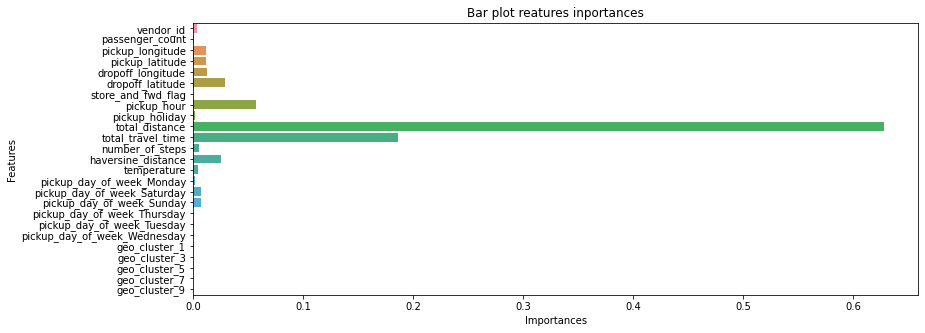

In [ ]:
fig, ax = plt.subplots(figsize=(13, 5))
#feature = X.columns
feature_importances = gb.feature_importances_
sns.barplot(y=best_features, x=feature_importances, ax=ax, orient='h')
ax.set_title('Bar plot reatures inportances')
ax.set_ylabel('Features')
ax.set_xlabel('Importances')

Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведем в минуты и округлим до десятых.


In [ ]:
y_valid = np.exp(y_valid_log) - 1
y_valid_pred = np.exp(gb.predict(X_valid_scaler)) - 1
print('Valid MAE error: {:.1f}'.format(metrics.median_absolute_error(y_valid_pred, y_valid) / 60))


Valid MAE error: 1.8


Сделаем submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных.


In [ ]:
test_data = drive.CreateFile({'id': '18DqXvfXj3KyAbd8th3rHcWYfZ__jH9S1'})
test_data.GetContentFile('data/test_data.csv')

osrm_data_test = drive.CreateFile({'id': '1pesjhoIAT_Qiych8iTq0laGeBtCbFZfv'})
osrm_data_test.GetContentFile('data/osrm_data_test.csv')

In [ ]:
test_data = pd.read_csv("data/test_data.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки произведем все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Переведем признак pickup_datetime в формат datetime;
* Добавим новые признаки (временные, географические, погодные и другие факторы);
* Произведем очистку данных от пропусков;
* Произведем кодировку категориальных признаков:
    * Закодируем бинарные признаки;
    * Закодируем номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформируем матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализуем данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Shape of data: (625134, 25)


In [ ]:
# Делаем предсказание для тестовой выборки.
y_test_predict = ens_tr.predict(X_test_scaled)
# Выводим метрику.
# print('RMSLE metric - {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_test_predict))))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   10.4s finished


Сделаем предсказание длительности поездки для тестовой выборки.




In [ ]:
y_test_predict = ens_tr.predict(X_test_scaled)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   10.2s finished


Код для создания submission-файла:

In [ ]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

В завершение по ансамблевым методам попробуем улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Установим пакет xgboost:

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


После чего импортируем модуль:

In [ ]:
import xgboost as xgb

Перед обучением модели переведем наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaler, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaler, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42222	valid-rmse:5.42195
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[10]	train-rmse:1.93574	valid-rmse:1.93573
[20]	train-rmse:0.785234	valid-rmse:0.786137
[30]	train-rmse:0.478837	valid-rmse:0.480914
[40]	train-rmse:0.421021	valid-rmse:0.423779
[50]	train-rmse:0.408993	valid-rmse:0.412197
[60]	train-rmse:0.404108	valid-rmse:0.407671
[70]	train-rmse:0.400594	valid-rmse:0.4046
[80]	train-rmse:0.398388	valid-rmse:0.402701
[90]	train-rmse:0.396768	valid-rmse:0.401388
[100]	train-rmse:0.395176	valid-rmse:0.400023
[110]	train-rmse:0.393696	valid-rmse:0.398855
[120]	train-rmse:0.392518	valid-rmse:0.397931
[130]	train-rmse:0.391612	valid-rmse:0.397244
[140]	train-rmse:0.390703	valid-rmse:0.396796
[150]	train-rmse:0.389516	valid-rmse:0.395898
[160]	train-rmse:0.38873	valid-rmse:0.395376
[170]	train-rmse:0.387849	valid-rmse:0.394806
[180]	train-rmse:0.386985	valid-rmse:0.394237

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39089


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


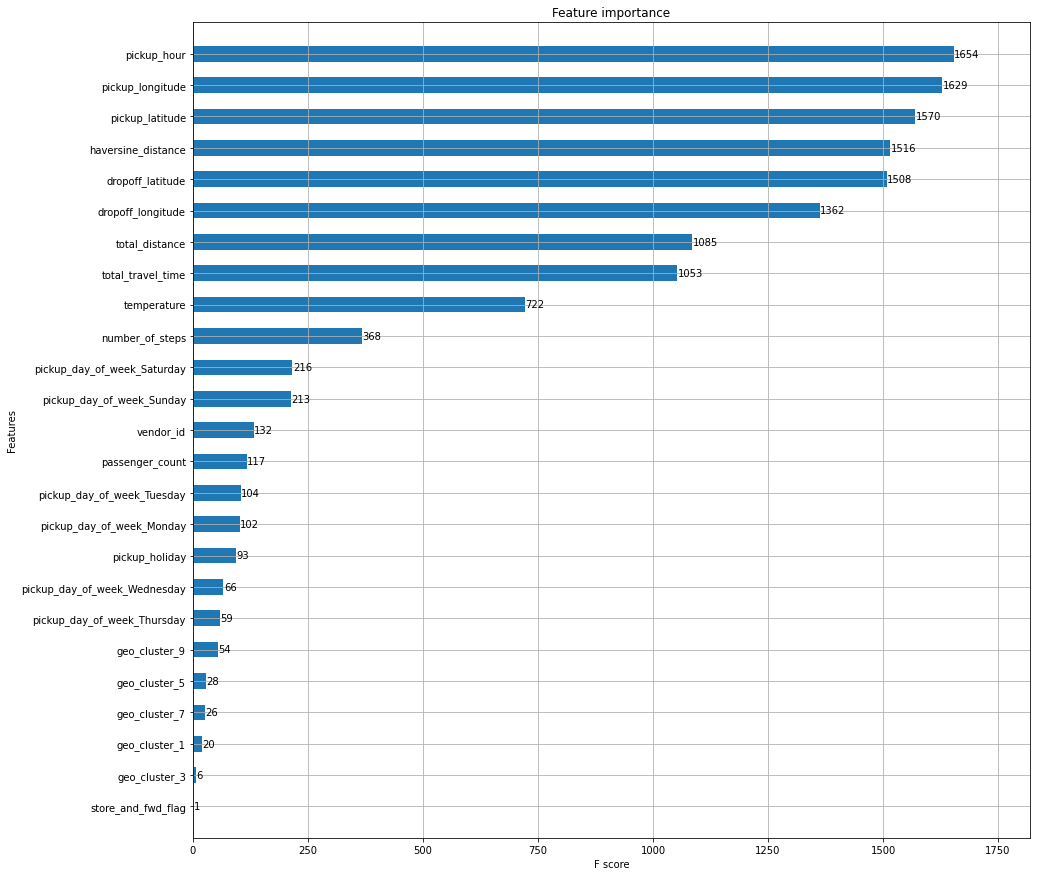

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)